In [1]:
from biom.parse import parse_biom_table
from cogent.maths.stats.rarefaction import rarefaction
from IPython.display import FileLink
import pandas as pd
import pandas.rpy.common as com
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda/lib/python2.7/site-packages/pandas/rpy/__init__.py:8: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2, found here: http://rpy.sourceforge.net
  "like rpy2, found here: http://rpy.sourceforge.net", FutureWarning)


In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(plyr); library(dplyr)
library(phyloseq)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [4]:
otu_table = parse_biom_table(open("../data/A/otu_table.wtax.biom"))
otu_table_norm = otu_table.normObservationBySample()

In [5]:
def f(ov, oid, omd):
    if omd["taxonomy"][0] == "Eukaryota":
        return True
    else:
        return False
otu_table_euks = otu_table.filterObservations(f)

In [6]:
pw_comps = (("B4.24.7.10","P4.24.7.10"),
            ("B3.15.7.10","P3.15.7.10"),
            ("B3.24.7.10","P3.24.7.10"),
            ("B2.15.7.10","P2.15.7.10"),
            ("B2.24.7.10","P2.24.7.10"),
            ("B1.15.7.10","P1.15.7.10"),
            ("B1.24.7.10","P1.24.7.70"))

In [7]:
data1 = otu_table_euks.sampleData("B4.24.7.10")
data2 = otu_table_euks.sampleData("P4.24.7.10")
print data1.sum(), data2.sum()

560.0 613.0


In [8]:
data1.nonzero()[0].shape

(52,)

In [9]:
def get_raref_vector(data, stride=10, iters=25):
    rare_data = vstack([[len(h.nonzero()[0]) for h in rarefaction(data, stride=stride)] \
                        for i in range(iters)])
    X = arange(stride,data.sum()+stride,stride)
    return X, mean(rare_data, axis=0), std(rare_data, axis=0)

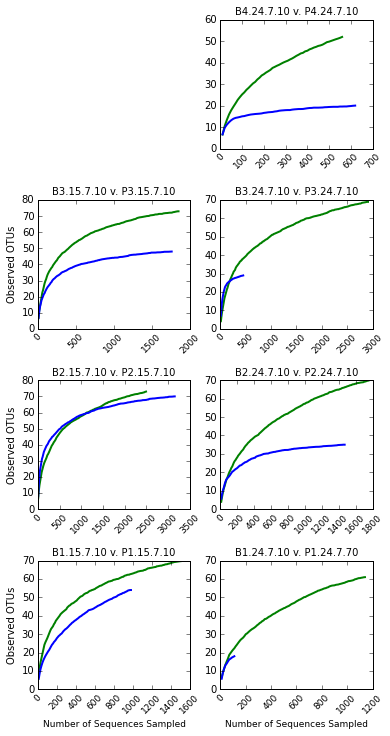

In [10]:
fig, axarr = plt.subplots(nrows=4, 
                          ncols=2,
                          figsize=(6,12))
axarr[0,0].set_visible(False)
fig.subplots_adjust(hspace=0.4)
for comp, ax in zip(pw_comps, axarr.reshape(-1)[1:]):
    data1 = otu_table_euks.sampleData(comp[0])
    data2 = otu_table_euks.sampleData(comp[1])
    X1, rare_data1, std1 = get_raref_vector(data1)
    X2, rare_data2, std2 = get_raref_vector(data2)
    ax.plot(X1, rare_data1, color='g', lw=2)
    ax.plot(X2, rare_data2, color='b', lw=2)
    ax.set_title("%s v. %s"%(comp[0], comp[1]),
                 size=10)
    for xlab in ax.get_xticklabels():
        xlab.set_rotation(45)
        xlab.set_size(9)

for ax in axarr[3,:]:
    ax.set_xlabel("Number of Sequences Sampled", size=9)

for ax in axarr[:,0]:
        ax.set_ylabel("Observed OTUs")

fig.savefig("figs/algae_rarefaction_curves.pdf")

In [11]:
otu_table_bact = parse_biom_table(open("../data/B/otu_table.wtax_wsd.biom"))
otu_table_euk = parse_biom_table(open("../data/A/otu_table.wtax_wsd.biom"))

In [12]:
t = otu_table_euk
    
dfs = {}
for sid in t.SampleIds:
    counts = t.sampleData(sid)
    x, raref_data, stddev = get_raref_vector(counts)
    dfs[sid] = pd.DataFrame(data={"x" : x, "y" : raref_data, "stddev" : stddev})
    
df_all = pd.concat(dfs, axis=0)
df_all = df_all.reset_index()
df_all.drop(["level_1"], axis=1, inplace=True)
df_all.rename(columns = {"level_0" : "SampleID"}, inplace=True)
sample_data = pd.read_csv("../data/chachie_mapper_A.txt", sep="\t")
sample_data.rename(columns={"#SampleID" : "SampleID"}, inplace=True)
df_euk = df_all.merge(sample_data, on="SampleID") 
df_euk.head()

,SampleID,stddev,x,y,BarcodeSequence,LinkerPrimerSequence,ReversePrimer,EnvironmentType,Experiment,CarbonToPhosphorous,HighLow,Date,Description
0,B1.15.7.10,1.261111,10,7.64,GTTGATTA,GGACAGAAAGACCCTATGAA,TCAGCCTGTTATCCCTAGAG,biofilm,B1,500,high,8,B1_15.7.10
1,B1.15.7.10,2.059126,20,13.40,GTTGATTA,GGACAGAAAGACCCTATGAA,TCAGCCTGTTATCCCTAGAG,biofilm,B1,500,high,8,B1_15.7.10
2,B1.15.7.10,2.246419,30,17.56,GTTGATTA,GGACAGAAAGACCCTATGAA,TCAGCCTGTTATCCCTAGAG,biofilm,B1,500,high,8,B1_15.7.10
3,B1.15.7.10,2.464467,40,20.92,GTTGATTA,GGACAGAAAGACCCTATGAA,TCAGCCTGTTATCCCTAGAG,biofilm,B1,500,high,8,B1_15.7.10
4,B1.15.7.10,2.624805,50,23.48,GTTGATTA,GGACAGAAAGACCCTATGAA,TCAGCCTGTTATCCCTAGAG,biofilm,B1,500,high,8,B1_15.7.10


In [13]:
pd.read_csv("../data/chachie_mapper_B.txt", sep="\t")

,#SampleID,BarcodeSequence,LinkerPrimerSequence,ReversePrimer,Variable,CarbonToPhosphorous,HighLow,EnvironmentType,Experiment,Date,Description
0,B1.15.7.10,ACCGCACA,GAGTTTGATCNTGGCTCAG,GTNTTACNGCGGCKGCTG,L,500,high,biofilm,B1,8,B1_15.7.10
1,B1.24.7.10,ACGCCGCA,GAGTTTGATCNTGGCTCAG,GTNTTACNGCGGCKGCTG,H,500,high,biofilm,B1,17,B1_24.7.10
2,B2.15.7.10,ACCTCTAA,GAGTTTGATCNTGGCTCAG,GTNTTACNGCGGCKGCTG,L,100,low,biofilm,B2,8,B2_15.7.10
3,B2.24.7.10,ACGGAGTA,GAGTTTGATCNTGGCTCAG,GTNTTACNGCGGCKGCTG,L,100,low,biofilm,B2,17,B2_24.7.10
4,B3.15.7.10,ACGAATGA,GAGTTTGATCNTGGCTCAG,GTNTTACNGCGGCKGCTG,L,10,low,biofilm,B3,8,B3_15.7.10
5,B3.24.7.10,ACGGTTCA,GAGTTTGATCNTGGCTCAG,GTNTTACNGCGGCKGCTG,L,10,low,biofilm,B3,17,B3_24.7.10
6,B4.24.7.10,ACGTGTTA,GAGTTTGATCNTGGCTCAG,GTNTTACNGCGGCKGCTG,L,control,low,biofilm,B4,17,B4_24.7.10
7,P1.15.7.10,ACCTAATA,GAGTTTGATCNTGGCTCAG,GTNTTACNGCGGCKGCTG,L,500,high,planktonic,P1,8,P1_15.7.10
8,P1.24.7.70,ACGCTAGA,GAGTTTGATCNTGGCTCAG,GTNTTACNGCGGCKGCTG,H,500,high,planktonic,P1,17,P1_24.7.70
9,P2.15.7.10,ACCTTCCA,GAGTTTGATCNTGGCTCAG,GTNTTACNGCGGCKGCTG,L,100,low,planktonic,P2,8,P2_15.7.10


In [14]:
t = otu_table_bact

dfs = {}
for sid in t.SampleIds:
    counts = t.sampleData(sid)
    x, raref_data, stddev = get_raref_vector(counts)
    dfs[sid] = pd.DataFrame(data={"x" : x, "y" : raref_data, "stddev" : stddev})   
    
df_all = pd.concat(dfs, axis=0)
df_all = df_all.reset_index()
df_all.drop(["level_1"], axis=1, inplace=True)
df_all.rename(columns = {"level_0" : "SampleID"}, inplace=True)
sample_data = pd.read_csv("../data/chachie_mapper_A.txt", sep="\t")
sample_data.rename(columns={"#SampleID" : "SampleID"}, inplace=True)
df_bact = df_all.merge(sample_data, on="SampleID") 
df_bact.head()

,SampleID,stddev,x,y,BarcodeSequence,LinkerPrimerSequence,ReversePrimer,EnvironmentType,Experiment,CarbonToPhosphorous,HighLow,Date,Description
0,B1.15.7.10,1.400571,10,7.72,GTTGATTA,GGACAGAAAGACCCTATGAA,TCAGCCTGTTATCCCTAGAG,biofilm,B1,500,high,8,B1_15.7.10
1,B1.15.7.10,1.835647,20,13.52,GTTGATTA,GGACAGAAAGACCCTATGAA,TCAGCCTGTTATCCCTAGAG,biofilm,B1,500,high,8,B1_15.7.10
2,B1.15.7.10,2.431131,30,18.64,GTTGATTA,GGACAGAAAGACCCTATGAA,TCAGCCTGTTATCCCTAGAG,biofilm,B1,500,high,8,B1_15.7.10
3,B1.15.7.10,2.720588,40,23.72,GTTGATTA,GGACAGAAAGACCCTATGAA,TCAGCCTGTTATCCCTAGAG,biofilm,B1,500,high,8,B1_15.7.10
4,B1.15.7.10,2.621755,50,27.92,GTTGATTA,GGACAGAAAGACCCTATGAA,TCAGCCTGTTATCCCTAGAG,biofilm,B1,500,high,8,B1_15.7.10


In [15]:
df_bact = com.convert_to_r_dataframe(df_bact)
df_euk = com.convert_to_r_dataframe(df_euk)

In [16]:
%Rpush df_bact
%Rpush df_euk

In [17]:
%%R
df.both = ldply(list(Photoautotrophs = df_euk, '"Heterotrophs"' = df_bact))
colnames(df.both)[1] = "libraryType"
print(head(df.both))

      libraryType   SampleID       stddev  x     y BarcodeSequence
1 Photoautotrophs B1.15.7.10 1.261110.... 10  7.64        GTTGATTA
2 Photoautotrophs B1.15.7.10 2.059126.... 20  13.4        GTTGATTA
3 Photoautotrophs B1.15.7.10 2.246419.... 30 17.56        GTTGATTA
4 Photoautotrophs B1.15.7.10 2.464467.... 40 20.92        GTTGATTA
5 Photoautotrophs B1.15.7.10 2.624804.... 50 23.48        GTTGATTA
6 Photoautotrophs B1.15.7.10 3.076621.... 60 26.12        GTTGATTA
  LinkerPrimerSequence        ReversePrimer EnvironmentType Experiment
1 GGACAGAAAGACCCTATGAA TCAGCCTGTTATCCCTAGAG         biofilm         B1
2 GGACAGAAAGACCCTATGAA TCAGCCTGTTATCCCTAGAG         biofilm         B1
3 GGACAGAAAGACCCTATGAA TCAGCCTGTTATCCCTAGAG         biofilm         B1
4 GGACAGAAAGACCCTATGAA TCAGCCTGTTATCCCTAGAG         biofilm         B1
5 GGACAGAAAGACCCTATGAA TCAGCCTGTTATCCCTAGAG         biofilm         B1
6 GGACAGAAAGACCCTATGAA TCAGCCTGTTATCCCTAGAG         biofilm         B1
  CarbonToPhosphorous HighLow Date

Don't know how to automatically pick scale for object of type AsIs. Defaulting to continuous


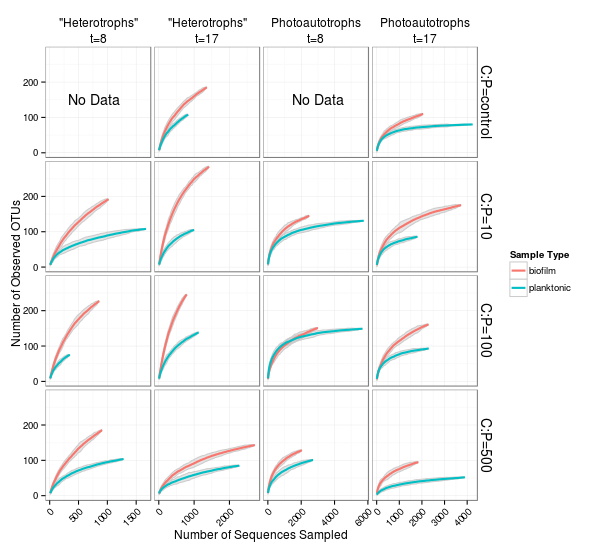

In [18]:
%%R -w 600 -h 550
library(ggplot2)
df.both$x = as.numeric(df.both$x)
df.both$y = as.numeric(df.both$y)
df.both$EnvironmentType = as.factor(df.both$EnvironmentType)
df.both$Date.strip = factor(paste("t=",df.both$Date,sep=""), levels = c("t=8", "t=17"))
df.both$CarbonToPhosphorous.strip = factor(paste("C:P=",df.both$CarbonToPhosphorous,sep=""),
                                            levels = c("C:P=control", 
                                                       "C:P=10", 
                                                       "C:P=100", 
                                                       "C:P=500"))
p = ggplot(df.both, aes(x = x, y = y, color = EnvironmentType)) 
p = p + geom_ribbon(alpha = 0.25, 
                    color = "gray80",
                    fill = "gray60",
                    aes(ymin = y - qnorm(0.99) * stddev, 
                                     ymax = y + qnorm(0.99) * stddev,
                        group = EnvironmentType))
p = p + geom_line(aes(color = EnvironmentType), size=1)
p = p + facet_grid(CarbonToPhosphorous.strip ~ libraryType + Date.strip, scales = "free_x")
p = p + xlab("Number of Sequences Sampled")
p = p + ylab("Number of Observed OTUs")

d = data.frame(CarbonToPhosphorous.strip = "C:P=control",
               libraryType = c("Photoautotrophs", '"Heterotrophs"'),
               Date.strip = "t=8",
               x = c(3000, 775),
               y = 150,
               t = "No Data")

p = p + geom_text(data = d, aes(label = t, x = x, y = y), color = "black")

p = p + theme_bw()
p = p + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1), 
              strip.text.x = element_text(size = 12), 
              strip.text.y = element_text(size = 14),
              strip.background = element_blank())
p = p + labs(color = "Sample Type")
p

In [19]:
%%R
ggsave("figs/combined_rarefaction.pdf", p, h = 8, w = 8)

Don't know how to automatically pick scale for object of type AsIs. Defaulting to continuous


In [20]:
FileLink("figs/combined_rarefaction.pdf")

/home/chuck/working/carbon_subsidies_biofilm_plankton/BvP_manuscript_figures/figures_and_stats/figs/combined_rarefaction.pdf

In [21]:
%%R
ps.B = import_biom("../data/B/otu_table.wtax_wsd.biom")
ps.B = subset_samples(ps.B, EnvironmentType=="planktonic")
OTU_avg_B = apply(otu_table(ps.B), 1, sum)

In [22]:
%%R
ps.A = import_biom("../data/A/otu_table.wtax_wsd.biom")
ps.A = subset_samples(ps.A, EnvironmentType=="planktonic")
OTU_avg_A = apply(otu_table(ps.A), 1, sum)

In [23]:
%%R
ps.B

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 636 taxa and 7 samples ]
sample_data() Sample Data:       [ 7 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 636 taxa by 7 taxonomic ranks ]


In [24]:
%%R
ps.A

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 359 taxa and 7 samples ]
sample_data() Sample Data:       [ 7 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 359 taxa by 9 taxonomic ranks ]


In [25]:
data_planktonic_bact = %Rget OTU_avg_B
data_planktonic_euk = %Rget OTU_avg_A

In [26]:
X_bact, Y_bact, std_bact = get_raref_vector(np.array(data_planktonic_bact))
X_euk, Y_euk, std_euk = get_raref_vector(np.array(data_planktonic_euk))

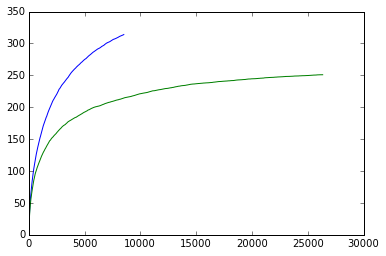

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_bact, Y_bact)
ax.plot(X_euk, Y_euk)

In [28]:
%Rpush X_bact Y_bact X_euk Y_euk std_bact std_euk

Don't know how to automatically pick scale for object of type AsIs. Defaulting to continuous
Don't know how to automatically pick scale for object of type AsIs. Defaulting to continuous


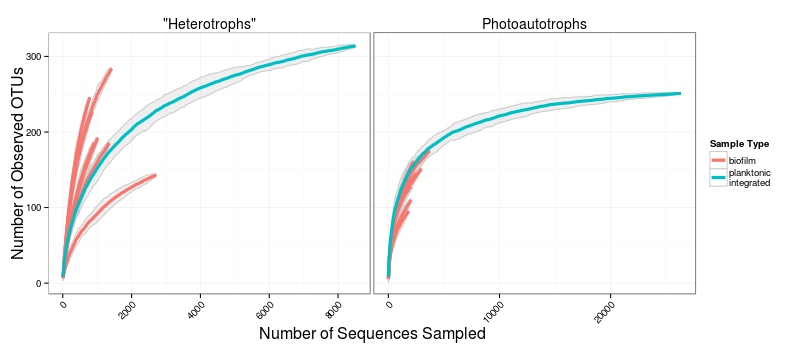

In [32]:
%%R -w 800 -h 350

df.integrate.bact = data.frame(x = X_bact, 
                           y = Y_bact, 
                           stddev = std_bact, 
                           libraryType = '"Heterotrophs"', 
                           Sample = "integrage", 
                           EnvironmentType = "planktonic\nintegrated")

df.integrate.euk = data.frame(x = X_euk, 
                           y = Y_euk, 
                           stddev = std_euk,   
                           libraryType = "Photoautotrophs", 
                           Sample = "integrage", 
                           EnvironmentType = "planktonic\nintegrated")

d = rbind.fill(df.integrate.bact, 
               df.integrate.euk, 
               df.both[df.both$EnvironmentType=="biofilm",])

d$EnvironmentType = factor(d$EnvironmentType, levels = c("biofilm", "planktonic\nintegrated"))

p = ggplot(d, aes(x = x, y = y, group = SampleID, color = EnvironmentType))

p = p + facet_wrap( ~ libraryType, scales = "free_x")
p = p + geom_ribbon(alpha = 0.15, 
                    color = "gray80",
                    fill = "gray60",
                    aes(ymin = y - qnorm(0.99) * stddev, 
                        ymax = y + qnorm(0.99) * stddev))
p = p + geom_line(size = 1.5)

p = p + xlab("Number of Sequences Sampled")
p = p + ylab("Number of Observed OTUs")
p = p + labs(color = "Sample Type")

p = p + theme_bw()

p = p + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1), 
              strip.text.x = element_text(size = 14), 
              axis.title.x = element_text(size = 16), 
              axis.title.y = element_text(size = 16), 
              strip.background = element_blank())

p.integ = p 

p

In [33]:
%%R
ggsave("figs/integrated_rarefaction.pdf", p.integ, h = 5, w = 10)

Don't know how to automatically pick scale for object of type AsIs. Defaulting to continuous
Don't know how to automatically pick scale for object of type AsIs. Defaulting to continuous


In [34]:
FileLink("figs/integrated_rarefaction.pdf")

/home/chuck/working/carbon_subsidies_biofilm_plankton/BvP_manuscript_figures/figures_and_stats/figs/integrated_rarefaction.pdf